# Bent electromagnetic 3d waveguide with PML


### by M. Wess, 2025
*This Notebook is part of the `dualcellspaces` [documentation](https://ngsolve.github.io/dcm) for the addon package implementing the Dual Cell method in [NGSolve](https://ngsolve.org).*

In [1]:
#import libraries

from ngsolve import *
import dualcellspaces as dcs
from ngsolve.webgui import Draw

import numpy as np
import matplotlib.pyplot as pl

In [2]:
#set geometry parameters

l_in = 0.2         # length of straight inflow waveguide
l_out = 0.2        # length of straight outflow waveguide
l_pml = 0.6        # length of pml at in- and outflow

d = 0.5            # width of waveguide
h = 0.2            # height of waveguide

rad = 0.3          # radius of bend


# problem parameters

c = 5
t0 = 1   
omega = 10

sigma = 10       # pml damping



# discretization parameters

maxh = 0.1  # mesh size
order = 2   # polynomial order


In [3]:
# create geometry with occ

from netgen.occ import *
wps = []
wps.append(MoveTo(-l_pml,-d/2).Rectangle(l_pml,d))
wps.append(MoveTo(0,-d/2).Rectangle(l_in,d)) 
wps.append(MoveTo(l_in,-d/2).Arc(d+rad,90).Rotate(90).Line(d).Rotate(90).Arc(rad,-90).Rotate(90).Line(d))
wps.append(MoveTo(l_in+rad,d/2+rad).Rectangle(d,l_out))
wps.append(MoveTo(l_in+rad,d/2+rad+l_out).Rectangle(d,l_pml))


mats = ["pmlx","wg","bend","wg","pmly"]
parts = []
for wp,mat in zip(wps,mats):
    parts.append(wp.Face().Extrude(h).mat(mat))
    #Draw(parts[-1])

wg3d = Glue(parts)


wg3d.faces.Nearest(Pnt(0,0,h/2)).name = "inflow"
wg3d.faces.Nearest(Pnt(l_in,0,h/2)).name = "sensor_in"
wg3d.faces.Nearest(Pnt(l_in+rad,d/2+l_out+rad,h/2)).name = "outflow"
wg3d.faces.Nearest(Pnt(l_in+rad,d/2+rad,h/2)).name = "sensor_out"
Draw(wg3d)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

In [4]:
# generate mesh
geo = OCCGeometry(wg3d)

mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(order)
Draw(mesh)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [5]:
#define spaces
fes_E = dcs.HCurlDualCells3D(mesh, order=order,dirichlet = mesh.Boundaries('default|inflow'))
fes_H = dcs.HCurlPrimalCells3D(mesh,order=order)

fes_E_pml = dcs.HCurlDualCells3D(mesh, order=order,dirichlet = mesh.Boundaries('default|inflow'))   # definedon not yet implemented
fes_H_pml = dcs.HCurlPrimalCells3D(mesh,order=order)

fes = fes_E*fes_E_pml*fes_H*fes_H_pml
print("total DoFs:",fes.ndof)
print("primary DoFs:",fes_E.ndof,", ",fes_H.ndof)
gf = GridFunction(fes)
gfE,gfE_, gfH,gfH_ = gf.components


#integral symbols with special integration rules
dxE = dx(intrules=fes_E.GetIntegrationRules())
dsE = ds(intrules=fes_E.GetIntegrationRules(),definedon=mesh.Boundaries('inflow'))
dxH = dx(intrules=fes_H.GetIntegrationRules())

dxw = dx(intrules=dcs.GetIntegrationRules(2*order+4))
dSw = dx(element_boundary=True,intrules=dcs.GetIntegrationRules(2*order+4))


#mixed bilinear form
E,dE = fes_E.TnT()
H,dH = fes_H.TnT()

normal = specialcf.normal(3)
bf_mixed = BilinearForm(E*curl(dH)*dxw+E*Cross(dH,normal)*dSw, geom_free=True).Assemble().mat

total DoFs: 1283820
primary DoFs: 325902 ,  316008


In [6]:
innerdofs_E = fes_E.GetDofs(mesh.Materials('default'))
pmldofs_E = fes_E.GetDofs(mesh.Materials('pmlx|pmly')) & ~fes_E.GetDofs(mesh.Boundaries('default|inflow'))

pmldofs_H = fes_H.GetDofs(mesh.Materials('pmlx|pmly'))

In [7]:
#prepare mass operators
with TaskManager():
    # (inverse) mass
    massH_inv = fes_H.Mass(1).Inverse()
    bfm_E = fes_E.Mass(1)
    massE_inv = bfm_E.Inverse(freedofs=fes_E.FreeDofs())
    
    # inverse mass in pml only   
    massH_inv_pml = fes_H.Mass(1).Inverse(freedofs = pmldofs_H)
    massE_inv_pml = fes_E.Mass(1).Inverse(freedofs = pmldofs_E)
    
    
    # surface mass for dirichlet data
    massE_surf = BilinearForm(E.Trace()*dE.Trace()*dsE).Assemble().mat
    massE_surf = massE_surf.DeleteZeroElements(1e-8)
    massE_surf_inv = massE_surf.Inverse(inverse='sparsecholesky',freedofs=fes_E.GetDofs(mesh.Boundaries('inflow')))
    
    # mass matrices for pml damping
    matcfy = CF((-1,0,0,0,1,0,0,0,-1))
    matcfx = CF((1,0,0,0,-1,0,0,0,-1))
    massH_damp = fes_H.Mass(mesh.MaterialCF({"default" : 0*Id(3), "pmlx": matcfx, "pmly": matcfy}))
    massE_damp = fes_E.Mass(mesh.MaterialCF({"default" : 0*Id(3), "pmlx": matcfx, "pmly": matcfy}))
    matcfy2 = CF((0,0,0,0,1,0,0,0,0))
    matcfx2 = CF((1,0,0,0,0,0,0,0,0))
    massH_x = fes_H.Mass(mesh.MaterialCF({"default" : 0*Id(3), "pmlx": matcfx2, "pmly": matcfy2}))
    massE_x = fes_E.Mass(mesh.MaterialCF({"default" : 0*Id(3), "pmlx": matcfx2, "pmly": matcfy2}))
    

used dof inconsistency
(silence this warning by setting BilinearForm(...check_unused=False) )


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

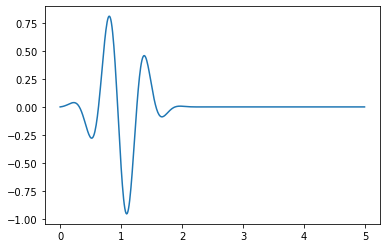

In [8]:
#dirichlet data
ply = pi/d
gfe=GridFunction(fes_E)
n = 1
lfr = LinearForm(InnerProduct(CF((0,0,cos(n*y*ply))),dE.Trace())*dsE).Assemble().vec
gfe.vec.data = massE_surf_inv*lfr
#print(gfe.vec)

#BoundaryProj = Projector(fes_E.GetDofs(mesh.Boundaries('inflow')),True)

Draw(gfe)
#rhsEfuncscal = lambda t: exp(-c*(t0-t)**2)*sin(omega*t)
rhsEfunc = lambda t: exp(-c*(t0-t)**2)*sin(omega*t)*gfe.vec

#rhsEfunc = lambda t: exp(-c*(t<t0)*(t0-t)**2)*sin(n*omega*t)*gfe.vec
#rhsEfuncscal = lambda t: exp(-c*IfPos(t0-t,1,0)*(t0-t)**2)*sin(n*omega*t)
#rhsEfunc = lambda t: 0*gfe.vec

#rhsEfunc = lambda t: sin(n*omega*t)*gfe.vec
#rhsEfuncscal = lambda t: sin(n*omega*t)



#visualize dirichlet data over time
ts = np.arange(0,5,0.01)
pl.plot(ts,np.exp(-c*(t0-ts)**2)*np.sin(omega*ts))
#pl.plot(ts,np.sin(omega*ts))
pl.show()

In [9]:
# estimate cfl condition using power iteration

def estimate_tau(mat, maxsteps = 2000, tol = 1e-9):   
    vec = mat.CreateColVector()
    vec.SetRandom()
    vec*=1/vec.Norm()
    tmp = vec.CreateVector()
    lam = 0
    
    for i in range(maxsteps):
        #print(i,end='\r')
        tmp.data = mat * vec
        
        lamnew = InnerProduct(tmp,vec)
        tau = 2/sqrt(lamnew)
        n = tmp.Norm()
        res = (tmp-lam*vec).Norm()/lamnew/n
        #print(res)
        tmp *= 1/n
        if res<tol: return tau
        vec.data = tmp
        lam = lamnew
    print("did not converge, last res = ",res)
    return tau

tau = estimate_tau(massE_inv@bf_mixed.T@massH_inv@bf_mixed)
tau *= 0.95
print("estimated tau = ", tau)

estimated tau =  0.0010769813797701121


In [10]:
#Draw solution
#scenee = Draw (gfE.Operator("altshape")[2], mesh, "E", order=2, draw_surf=False, clipping={"y":0, "z":-1},
#               min=-0.5,max=0.5,autoscale=False,points=dcs.GetWebGuiPoints(2),
#               settings = {"Objects" : {"Clipping Plane" : True}}, euler_angles=[0,0,0])

# or save solution in multivector for animation
gfE_anim = GridFunction(fes_E,multidim=0)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Clipping Plane':…

In [14]:
from time import time

drawevery = 100
tend = 4

t = 0.
i = 0

gfH.vec[:]=0
gfE.vec[:]=0

gfH_.vec[:]=0
gfE_.vec[:]=0




tmpE = gfE.vec.CreateVector()
tmpE_ = gfE.vec.CreateVector()
tmpH = gfH.vec.CreateVector()
tmpH_ = gfH.vec.CreateVector()

now = time()
timepassed = 0



with TaskManager():
    gfH.vec.data += -tau/2*massH_inv@bf_mixed*gfE.vec     #initial data in pml is zero, so first step does not need damping terms
    while t<tend:
        
        t+=tau       
        i+=1

        tmpE.data = tau*(bf_mixed.T*gfH.vec+sigma*(massE_damp*gfE.vec-massE_x*gfE_.vec))+bfm_E*(gfE.vec-rhsEfunc(t))
        tmpE_.data = massE_x*gfE.vec-massE_x*gfE_.vec
        gfE_.vec.data += tau*sigma*massE_inv_pml*tmpE_

        gfE.vec.data = rhsEfunc(t)
        gfE.vec.data += massE_inv*tmpE
        
        tmpH.data = -bf_mixed*gfE.vec+sigma*(massH_damp*gfH.vec-massH_x*gfH_.vec)
        tmpH_.data = massH_x*gfH.vec-massH_x*gfH_.vec
        gfH_.vec.data += tau*sigma*massH_inv_pml*tmpH_
            
        gfH.vec.data += tau*massH_inv*tmpH
        
        if i%drawevery == 0:
            timepassed += time()-now
            #scenee.Redraw() # for immediate drawing
            gfE_anim.AddMultiDimComponent(gfE.vec) #for saving to multidim function
           
            #print("\r time = {}, step = {}, {:e} dofs/s".format(t,i,i*fes.ndof/timepassed),end="")

            now = time()



 time = 4.954114346942407, step = 4600, 4.529587e+07 dofs/ss

In [17]:
print("finshed with an average of {:e} dofs/s".format(i*fes.ndof/timepassed),end="")
Draw (gfE_anim, 
      mesh, "E", order=2, draw_surf=False, clipping={"y":0, "z":-1},
      animate = True,
      min=-0.5,max=0.5,autoscale=False,points=dcs.GetWebGuiPoints(2),
      settings = {"eval": 2, "Objects" : {"Clipping Plane" : True}}, euler_angles=[0,0,0]);      

finshed with an average of 4.571928e+07 dofs/s

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'eval': 2, 'Objects': {'Clipp…